In [1]:
%config Completer.use_jedi = False
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from pandas.api.types import CategoricalDtype
import math
import matplotlib as mpl
#mpl.use('pdf')
import matplotlib.pyplot as plt
import matplotlib.font_manager
import numpy as np
from collections import OrderedDict
import matplotlib
import seaborn as sns
from pylab import cm
from matplotlib.cbook import boxplot_stats
from matplotlib.legend_handler import HandlerTuple

from scipy.stats.mstats import hmean

from pprint import pprint
from IPython.display import display, HTML

import os
import subprocess
# import pickle
import dill as pickle  # Use dill instead of pickle
import warnings 
warnings.filterwarnings('ignore', category=FutureWarning)

# Load any global variables (and functions) from pickle object (defined in benchmark_aggregation)
### (need to move color palette here, as well as dictionary device->color)

In [2]:
# Load the objects from the file
with open('objects.pkl', 'rb') as f:
    objects_to_load = pickle.load(f)

ranges_dev = objects_to_load['ranges_dev']
ranges_dev_backup = objects_to_load['ranges_dev_backup']
y_limit_dictionary = objects_to_load['y_limit_dictionary']
ranges_impl_arch = objects_to_load['ranges_impl_arch']
ranges_impl_arch_backup = objects_to_load['ranges_impl_arch_backup']
ranges_memr = objects_to_load['ranges_memr']
ranges_anr = objects_to_load['ranges_anr']
ranges_skew = objects_to_load['ranges_skew']
ranges_ann = objects_to_load['ranges_ann']
ranges_crs = objects_to_load['ranges_crs']
ranges_size = objects_to_load['ranges_size']
ranges_regularity = objects_to_load['ranges_regularity']
cat_list = objects_to_load['cat_list']
ranges_list = objects_to_load['ranges_list']

# functions
set_category = objects_to_load['set_category']
set_category2 = objects_to_load['set_category2']
filter_ranges_impl_arch = objects_to_load['filter_ranges_impl_arch']
calculate_format_wins = objects_to_load['calculate_format_wins']

---
# Load benchmark dataframes

In [16]:
%%time
groupreps = pd.read_csv('synthetic_benchmarks_all-devices_all.csv')
print('groupreps:', groupreps.shape)
group_system_best = pd.read_csv('synthetic_benchmarks_all-devices_best-of.csv')
print('group_system_best:', group_system_best.shape)

def remove_devices(df, devices_to_discard):
    for dtd in devices_to_discard:
        df = df[df['System'] != dtd]
    return df

devices_to_discard = []

groupreps = remove_devices(groupreps, devices_to_discard)
group_system_best = remove_devices(group_system_best, devices_to_discard)

print('\nAfter discarding specific devices')
print('groupreps:', groupreps.shape)
print('group_system_best:', group_system_best.shape)

groupreps: (1222089, 38)
group_system_best: (190519, 38)

After discarding specific devices
groupreps: (1222089, 38)
group_system_best: (190519, 38)
CPU times: user 4.69 s, sys: 357 ms, total: 5.05 s
Wall time: 5.06 s


---

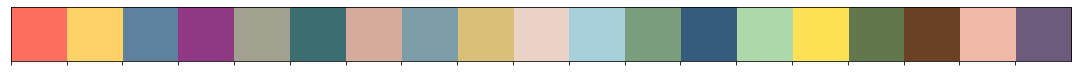

In [62]:
palette = [
    '#FF6F61','#FFD166','#5E819D','#8F3985','#A2A18F',
    '#3C6E71','#D5AB9C',
    '#7D9EA8', '#D9BF77','#EAD3C6',
    '#A8D0DB','#7A9D7E', '#355C7D',
    '#ACD8AA','#FFE156',
    '#63774D','#6B4226','#F0B8A6','#6C5B7B',
]
sns.palplot(palette)
plt.show()

In [64]:
def change_colors(ranges_dev, color_dictionary):
    color_dictionary_custom = {k: v for k, v in color_dictionary.items() if k in ranges_dev}
    sns.set_palette(color_dictionary_custom.values())
    sns.color_palette()


# all devices that will be used
ranges_dev = [
                'NVIDIA-P100', 'NVIDIA-V100', 'NVIDIA-A100', 'NVIDIA-H100', 'AMD-MI250',
                'AMD-EPYC-24', 'AMD-EPYC-64', 
                'INTEL-XEON-14', 'INTEL-ICY-16', 'INTEL-SAPPHIRE-56'
                'ARM-NEON-80', 'ARM-GRACE-72',
                'IBM-POWER9-32'
             ]

color_dictionary = dict(zip(ranges_dev, palette[:len(ranges_dev)]))

sns.set_palette(color_dictionary.values())
sns.color_palette()


[(1.0, 0.43529411764705883, 0.3803921568627451),
 (1.0, 0.8196078431372549, 0.4),
 (0.3686274509803922, 0.5058823529411764, 0.615686274509804),
 (0.5607843137254902, 0.2235294117647059, 0.5215686274509804),
 (0.6352941176470588, 0.6313725490196078, 0.5607843137254902),
 (0.23529411764705882, 0.43137254901960786, 0.44313725490196076),
 (0.8352941176470589, 0.6705882352941176, 0.611764705882353),
 (0.49019607843137253, 0.6196078431372549, 0.6588235294117647),
 (0.8509803921568627, 0.7490196078431373, 0.4666666666666667),
 (0.9176470588235294, 0.8274509803921568, 0.7764705882352941),
 (0.6588235294117647, 0.8156862745098039, 0.8588235294117647),
 (0.47843137254901963, 0.615686274509804, 0.49411764705882355)]

In [34]:
# original for IEEE paper
width = 3.487
height = width/1.618

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size': 7})

In [82]:
# "dodge" argument explained here -> https://stackoverflow.com/questions/49078697/seaborn-boxplots-shifted-incorrectly-along-x-axis 
def harry_plotter(type, plot_df, plot_x_axis_list, plot_y_axis_list, select_str, plot_id, 
                  boxplot_width = 0.8, rotation = 30, adj_left = .1, adj_bottom = .2, adj_right = .99, adj_top = .88, 
                  no_sort=False, hue_hue = 'None', hue_hue_order = [], dodge=True, no_legend=False, no_title=True,
                  show_size=False, systemaki='',
                  no_x_axis=False, no_x_axis_title=False, add_separators = False,
                  secondary_axis=False, plot_secondary_y_itter = '', secondary_data = [], secondary_annot = [],
                 ):
    for plot_x_itter in plot_x_axis_list:
        if no_sort:
            plot_df_sorted = plot_df
        else:
            dataTypeX = plot_df[plot_x_itter].dtype
            if dataTypeX == np.float64 or dataTypeX == np.int64 or dataTypeX == float or dataTypeX == int:
                plot_df_sorted = plot_df.sort_values(plot_x_itter)
            else:
                plot_df_sorted = plot_df
                if plot_x_itter == 'mem_range':
                    cat_it = CategoricalDtype(ranges_memr, ordered=True)
                if plot_x_itter == 'regularity':
                    cat_it = CategoricalDtype(ranges_regularity, ordered=True)
                if plot_x_itter == 'impl_arch':
                    cat_it = CategoricalDtype(ranges_impl_arch, ordered=True)
                if plot_x_itter == 'System':
                    cat_it = CategoricalDtype(ranges_dev, ordered=True)
                if plot_x_itter == 'anr_categ':
                    cat_it = CategoricalDtype(ranges_anr, ordered=True)
                if plot_x_itter == 'skew_categ':
                    cat_it = CategoricalDtype(ranges_skew, ordered=True)

                plot_df_sorted[plot_x_itter] = plot_df_sorted[plot_x_itter].astype(cat_it)
                plot_df_sorted = plot_df_sorted.sort_values(plot_x_itter)

        for plot_y_itter in plot_y_axis_list:
            fig, axs = plt.subplots()
            if hue_hue == 'None':
                if(type == 'violin'):
                    sns_plot = sns.violiplot(linewidth=0.6, width=0.4, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, ax=axs, dodge=dodge)
                if(type == 'scatter'):
                    sns_plot = sns.scatterplot(data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, ax=axs)
                if(type == 'box'):
                    sns_plot = sns.boxplot(fliersize = 0.3, linewidth=0.6, width=boxplot_width, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, ax=axs, dodge=dodge)
            else:
                if(hue_hue_order != []):
                    if(type == 'violin'):
                        sns_plot = sns.violinplot(linewidth=0.6, width=0.4, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, hue_order=hue_hue_order, ax=axs, dodge=dodge)
                    if(type == 'scatter'):
                        sns_plot = sns.scatterplot(data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, hue_order=hue_hue_order, ax=axs)
                    if(type == 'box'):
                        sns_plot = sns.boxplot(fliersize = 0.3, linewidth=0.6, width=boxplot_width, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, hue_order=hue_hue_order, ax=axs, dodge=dodge)
                else:
                    if(type == 'violin'):
                        sns_plot = sns.violinplot(linewidth=0.6, width=0.4, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, ax=axs, dodge=dodge)
                    if(type == 'scatter'):
                        sns_plot = sns.scatterplot(data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, ax=axs)
                    if(type == 'box'):
                        sns_plot = sns.boxplot(fliersize = 0.3, linewidth=0.6, width=boxplot_width, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, ax=axs, dodge=dodge)

            if(hue_hue_order != []):               
                # reordering the labels
                handles, labels = plt.gca().get_legend_handles_labels()
                order = [labels.index(i) for i in hue_hue_order]
                plt.legend([handles[i] for i in order], [labels[i] for i in order], 
                           title = hue_hue.replace('_categ',''), fancybox=True, frameon=False)

            if(no_legend==True):
                axs.get_legend().remove()
            else:
                #remove title from Legend
                handles, labels = axs.get_legend_handles_labels()
                axs.legend(handles=handles[0:], labels=labels[0:])
                # axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=len(ranges_dev), frameon=False)
                axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=len(ranges_dev), frameon=False)

            if(plot_x_itter == 'impl_arch'):
                if(add_separators  == True):
                    add_where = []
                    xtick_items = axs.get_xticklabels()
                    prev_platf = xtick_items[0].get_text().split('\t')[0] # initialize previous platform
                    for item in xtick_items:
                        platf = item.get_text().split('\t')[0]
                        if(platf!=prev_platf):
                            # when changing which platform is shown, add a separator right before
                            # to make it distinct from previous
                            add_where.append(item.get_position()[0]-0.5)
                        prev_platf = platf
                            
                    for pos in add_where:
                        plt.axvline(x=pos, color='gray', linewidth=0.15)
                
                # remove "arch" from "impl_arch"
                labels = [item.get_text().split("\t")[1] for item in axs.get_xticklabels()]
                axs.set_xticklabels(labels)
                axs.set_xlabel('Format name')

            if(plot_y_itter == 'energy_efficiency'):
                axs.set_ylabel("GFLOPs/W")
                # I set this limit as some outliers ( from Vectorized CSR ) caused it to reach 2.5
                # and compared to other devices, offered nothing more
                axs.set_ylim(bottom = 0, top=1.4)
            if(plot_y_itter == 'GFLOPs^2-per-W'):
                axs.set_ylabel("GFLOPs^2/W")
            if(plot_y_itter == 'gflops'):
                axs.set_ylabel("GFLOPs")
            if(plot_x_itter == 'anr_categ'):
                axs.set_xlabel('avg_nnz_per_row')
            if(plot_x_itter == 'skew_categ'):
                axs.set_xlabel('skew_coefficient')
            if(plot_x_itter == 'regularity'):
                axs.set_xlabel('regularity ( cross_row_similarity / avg_num_neighbours )')

            if(no_title==False):
                # axs.set_title('Select: %s' %(select_str))
                axs.set_title('%s' %(select_str))

            if(show_size==True):
                if(plot_x_itter=='System' or plot_x_itter=='mem_range' or plot_x_itter=='regularity' or plot_x_itter=='anr_categ' or plot_x_itter=='skew_categ'):
                    labels_new = [item.get_text() + '\n('+ str(plot_df_sorted[plot_df_sorted[plot_x_itter]==item.get_text()].shape[0])  +')' for item in axs.get_xticklabels()]
                else:
                    labels_new = [item.get_text() + '\n('+ str(plot_df_sorted[plot_df_sorted[plot_x_itter]==float(item.get_text())].shape[0])  +')' for item in axs.get_xticklabels()]
                axs.set_xticklabels(labels_new, fontsize = font)
                plt.xticks(rotation=45)#rotation)

            if(no_x_axis_title==True):
                axs.set_xlabel("")
            if(no_x_axis==True):
                axs.set_xticklabels([])
                axs.set_xlabel("")
                axs.set_xticks([], minor=False)#, major=False)
                
            if(secondary_axis==True):
                axs2 = axs.twinx()
                axs2.bar(range(0, len(secondary_data)), height=secondary_data,align='center', width = 0.6, alpha=0.19)
                
                if(plot_secondary_y_itter == 'mem_bw'):
                    axs2.set_ylabel("Memory Bandwidth (GB/s)")
                if(plot_secondary_y_itter == 'wins'):
                    axs2.set_ylabel("Wins percentage (%)")
                
                if(secondary_annot != []):
                    items = axs.get_xticklabels()
                    labels = [items[i].get_text() + '\n' + '(' + str(secondary_annot[i]) + '% peak performance)'  for i in range(len(items))]
                    axs.set_xticklabels(labels)

            if(systemaki != ''):
                axs.text( 0.02, 0.9, systemaki, fontsize=font, transform = axs.transAxes, )

            fig.subplots_adjust(left=adj_left, bottom=adj_bottom, right=adj_right, top=adj_top)

            plt.xticks(rotation=rotation)
            plt.setp( axs.xaxis.get_majorticklabels(), rotation=rotation )

            plt.tight_layout()

            select_str_id = select_str.replace('=', 'eq').replace('<', 'l').replace('>', 'g').replace(', ', '_').replace(',', '_').replace('\n', '_').replace(' ', '-')            
            if('-performance_' in select_str_id):
                select_str_id = select_str_id.split('-performance_')[0]
            else:
                select_str_id = select_str_id.split('__')[0]

            fig_name = './Plots/%s_Select-%s_x-%s_y-%s.pdf' % (plot_id, select_str_id, plot_x_itter, plot_y_itter)
            fig.savefig(fig_name)            
            plt.close()
            subprocess.run(['pdfcrop', fig_name], stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)
            subprocess.run(['mv', fig_name.replace('.pdf', '-crop.pdf'), fig_name])


---
---

# wins per format per device (percentage of each format that shows best performance for the matrices in the synthetic dataset)

In [74]:
ranges_dev = [
                'NVIDIA-P100', 'NVIDIA-V100', 'NVIDIA-A100', 'NVIDIA-H100', 'AMD-MI250',
                'AMD-EPYC-24', 'AMD-EPYC-64', 
                'INTEL-XEON-14', 'INTEL-ICY-16', 'INTEL-SAPPHIRE-56',
                'ARM-NEON-80', 'ARM-GRACE-72', 'IBM-POWER9-32'
             ]
for system in ranges_dev:
    print('---', system, '---')
    group_sys = group_system_best[group_system_best['System']==system]
    print(group_sys.shape)
    format_names = set(group_sys['format_name'])
    sys_shape = group_sys.shape[0]
    for impl in format_names:
        group_sys_impl = group_sys[group_sys['format_name']==impl]
        sys_impl_shape = group_sys_impl.shape[0]
        print(np.round(sys_impl_shape/sys_shape*100,2), '%', '\t', impl)
    print('---')

--- NVIDIA-P100 ---
(9918, 38)
20.45 % 	 cuSPARSE-CSR
24.22 % 	 cuSPARSE-COO
35.61 % 	 cuSPARSE-HYB
19.72 % 	 CSR5
---
--- NVIDIA-V100 ---
(12692, 38)
26.0 % 	 cuSPARSE-CSR
11.0 % 	 cuSPARSE-COO
33.75 % 	 cuSPARSE-HYB
29.25 % 	 CSR5
---
--- NVIDIA-A100 ---
(15362, 38)
55.44 % 	 cuSPARSE-CSR
39.49 % 	 cuSPARSE-COO
2.04 % 	 SELL-C-s
3.03 % 	 Merge-CSR
---
--- NVIDIA-H100 ---
(15249, 38)
65.79 % 	 cuSPARSE-CSR
0.25 % 	 dgal-4nnz
12.75 % 	 Ada-CSR
2.74 % 	 cuSPARSE-COO
9.92 % 	 DASP
4.49 % 	 Vec-CSR
4.05 % 	 CSR5
---
--- AMD-MI250 ---
(15249, 38)
1.72 % 	 ACC-Line
14.72 % 	 Ada-CSR
48.06 % 	 rocSPARSE-CSR
8.59 % 	 ACC-Flat
7.5 % 	 rocSPARSE-COO
0.82 % 	 Vec-CSR
18.58 % 	 rocSPARSE-HYB
---
--- AMD-EPYC-24 ---
(15263, 38)
7.86 % 	 SELL-C-s
5.58 % 	 AOCL
18.42 % 	 MKL-IE
0.54 % 	 Naive-CSR
31.21 % 	 Vec-CSR
5.16 % 	 Merge-CSR
30.73 % 	 SparseX
0.5 % 	 CSR5
---
--- AMD-EPYC-64 ---
(15249, 38)
10.69 % 	 SELL-C-s
1.77 % 	 AOCL
4.63 % 	 MKL-IE
1.11 % 	 Naive-CSR
51.57 % 	 Vec-CSR
7.92 % 	 Merge-C

---
# Begin plotting

# GPU only comparison (one boxplot per device)
### Also, plot memory bandwidth of each device
### and on x-axis, show percentage of median performance vs max GPU perf


In [37]:
ranges_dev = ['NVIDIA-P100', 'NVIDIA-V100', 'NVIDIA-A100', 'NVIDIA-H100', 'AMD-MI250']
change_colors(ranges_dev, color_dictionary)

system2, system = 'System Comparison', ''  
plot_id = system2

select_str = 'GPU_ONLY_Comparison of SpMV Devices-(Performance)'

plot_x_axis = ['System']
plot_y_axis = ['gflops']

groupdata = group_system_best

ranges_impl_arch = filter_ranges_impl_arch(ranges_impl_arch_backup, groupdata, ranges_dev)

groupdata_GPU = groupdata[groupdata['Arch']=='GPU']

medians = []
maxs = []
bandwidths = [550 ,760, 1350, 3300, 1313]
gemms = [4700, 7000, 9700, 20585, 24585] # 20585 H100 is not measured!
for sys in ranges_dev:
    groupdata_GPU_sys = groupdata_GPU[groupdata_GPU['System']==sys]
    print(sys, '\tmedian', round(groupdata_GPU_sys['gflops'].median(),0), '\tmax', round(groupdata_GPU_sys['gflops'].max(),0))
    medians.append(groupdata_GPU_sys['gflops'].median())
    maxs.append(groupdata_GPU_sys['gflops'].max())
rel_perf = [round(100*x/y,2) for x,y in zip(medians, gemms)]
for i in range(len(ranges_dev)):
    print(ranges_dev[i], '\t', rel_perf[i], '% of peak performance')

plt.rc('figure', figsize=(2.5 * width,height))
harry_plotter('box', groupdata_GPU, plot_x_axis, plot_y_axis, select_str, plot_id, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False,
              no_x_axis_title=True, rotation=0, boxplot_width = 0.4,
              secondary_axis = True, plot_secondary_y_itter = 'mem_bw', secondary_data = bandwidths, secondary_annot = rel_perf)


NVIDIA-P100 	median 44.0 	max 71.0
NVIDIA-V100 	median 81.0 	max 130.0
NVIDIA-A100 	median 132.0 	max 220.0
NVIDIA-H100 	median 336.0 	max 605.0
AMD-MI250 	median 100.0 	max 224.0
NVIDIA-P100 	 0.94 % of peak performance
NVIDIA-V100 	 1.16 % of peak performance
NVIDIA-A100 	 1.37 % of peak performance
NVIDIA-H100 	 1.63 % of peak performance
AMD-MI250 	 0.41 % of peak performance


# Total System Comparison (CPU only) (best of each System)
# one boxplot per format 

In [73]:
ranges_dev = ['AMD-EPYC-24', 'AMD-EPYC-64', 'ARM-NEON-80', 'ARM-GRACE-72', 'INTEL-XEON-14', 'INTEL-ICY-16', 'IBM-POWER9-32']
change_colors(ranges_dev, color_dictionary)

system2, system = 'System Comparison', ''  
plot_id = system2

select_str = 'CPU_ONLY_Comparison of SpMV Implementations-Formats-(Performance)'

plot_x_axis = ['impl_arch']
plot_y_axis = ['gflops']

groupdata = group_system_best

ranges_impl_arch = filter_ranges_impl_arch(ranges_impl_arch_backup, groupdata, ranges_dev)

# harry_plotter('violin', group_system_best_select, plot_x_axis, plot_y_axis, select_str, plot_id, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False)
groupdata_CPU = groupdata[groupdata['Arch']=='CPU']

wins = calculate_format_wins(ranges_impl_arch, groupdata, ranges_dev)

plt.rc('figure', figsize=(3 * width,1.2 * height))
harry_plotter('box', groupdata_CPU, plot_x_axis, plot_y_axis, select_str, plot_id, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False,
             no_x_axis_title=True, rotation=60, boxplot_width = 0.4, add_separators = True,
             secondary_axis = True, plot_secondary_y_itter = 'wins', secondary_data = wins)


# Now all (all important devices for journal...)

In [72]:
ranges_dev = [
                'NVIDIA-H100', 'AMD-MI250',
                'AMD-EPYC-64', 
                'INTEL-SAPPHIRE-56',
                'ARM-GRACE-72',
             ]
change_colors(ranges_dev, color_dictionary)
ranges_impl_arch = filter_ranges_impl_arch(ranges_impl_arch_backup, groupdata, ranges_dev)

system2, system = 'System Comparison', '' 
plot_id = system2

select_str = 'Comparison of SpMV Implementations-Formats-(Performance)'

plot_x_axis = ['impl_arch']
plot_y_axis = ['gflops']

groupdata = group_system_best

wins = calculate_format_wins(ranges_impl_arch, groupdata, ranges_dev)

plt.rc('figure', figsize=(2 * width,1.2 * height))
harry_plotter('box', groupdata, plot_x_axis, plot_y_axis, select_str, plot_id, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False,
             no_x_axis_title=True, rotation=90, boxplot_width = 0.4, add_separators = True,
             secondary_axis = True, plot_secondary_y_itter = 'wins', secondary_data = wins)

# select_str = 'Comparison of SpMV Implementations-Formats-(Energy Efficiency)'

# plot_x_axis = ['impl_arch']
# plot_y_axis = ['energy_efficiency']

# # harry_plotter('violin', group_system_best, plot_x_axis, plot_y_axis, select_str, plot_id, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False)
# # plt.rc('figure', figsize=(width,height*par))
# plt.rc('figure', figsize=(width*par2,height*par))
# harry_plotter('box', groupdata, plot_x_axis, plot_y_axis, select_str, plot_id, 
#               hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False, rotation=60)


# one boxplot per device

In [75]:
ranges_dev = ['NVIDIA-H100', 'AMD-MI250', 'AMD-EPYC-64', 'INTEL-SAPPHIRE-56', 'ARM-GRACE-72']
change_colors(ranges_dev, color_dictionary)
ranges_impl_arch = filter_ranges_impl_arch(ranges_impl_arch_backup, groupdata, ranges_dev)

system2, system = 'System Comparison', '' 
plot_id = system2

select_str = 'Comparison of SpMV Devices-(Performance)'
plot_x_axis = ['System']
plot_y_axis = ['gflops']

# groupdata = groupreps
groupdata = group_system_best

# medians = []
# maxs = []
# bandwidths = [550 ,760, 1935]

# gemms = [7000, 9700, 2100, 818, 970, 500, 150] # 2100 for AMD-HAWK is estimation. 500 for power9 too
# for sys in ranges_dev:
#     groupdata_sys = groupdata[groupdata['System']==sys]
#     print(sys, '\tmedian', round(groupdata_sys['gflops'].median(),0), '\tmax', round(groupdata_sys['gflops'].max(),0))
#     medians.append(groupdata_sys['gflops'].median())
#     maxs.append(groupdata_sys['gflops'].max())
# rel_perf = [round(100*x/y,2) for x,y in zip(medians, gemms)]
# for i in range(len(ranges_dev)):
#     print(ranges_dev[i], '\t', rel_perf[i], '% of peak performance')

plt.rc('figure', figsize=(1 * width,1 * height))
harry_plotter('box', groupdata, plot_x_axis, plot_y_axis, select_str, plot_id, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False, no_legend=True, 
              boxplot_width = 0.4, no_x_axis_title=False, no_x_axis=False)#, add_inside=False)


select_str = 'Comparison of SpMV Devices-(Energy Efficiency)'
plot_x_axis = ['System']
plot_y_axis = ['energy_efficiency']

plt.rc('figure', figsize=(1 * width,1 * height))
harry_plotter('box', groupdata, plot_x_axis, plot_y_axis, select_str, plot_id, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False, no_legend=True,
              boxplot_width = 0.4, rotation=30)#, add_inside=add_inside)
              # no_x_axis_title=True, no_x_axis=True)
              # rotation=0, no_x_axis_title=True)

# select_str = 'Comparison of SpMV Devices-(inverse EDP)'

# plot_x_axis = ['System']
# plot_y_axis = ['GFLOPs^2-per-W']
# # harry_plotter('violin', groupdata, plot_x_axis, plot_y_axis, select_str, plot_id, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False)
# # par=0.75
# par=1
# plt.rc('figure', figsize=(width*par3,height*par*par2))
# harry_plotter('box', groupdata, plot_x_axis, plot_y_axis, select_str, plot_id, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False, no_legend=True,
#              )
#               # rotation=0, no_x_axis_title=True)

In [76]:
ranges_dev = ['NVIDIA-H100', 'AMD-MI250', 'AMD-EPYC-64', 'INTEL-SAPPHIRE-56', 'ARM-GRACE-72']
groupdata = group_system_best
print('Max performance per System')
for system in ranges_dev:
    tmp = groupdata[groupdata['System']==system]
    print(system, '\t', round(tmp['gflops'].max()))

Max performance per System
NVIDIA-H100 	 605
AMD-MI250 	 224
AMD-EPYC-64 	 191
INTEL-SAPPHIRE-56 	 234
ARM-GRACE-72 	 265
